# Genre Prediction Based on Lyrics

## Introduzione
La relazione si pone l'obiettivo di definire un predittore di genere musicale basato su lyrics (testi delle canzoni). Il dataset utilizzato è una istanza di https://tmthyjames.github.io/2018/january/Cypher/ (Cypher, https://github.com/tmthyjames/cypher). Il progetto è attualmente dismesso, ma è possibile reperire in rete alcune istanze (tipicamente da altri progetti github). Il dataset consiste in un documento in formato CSV in cui sono presenti informazioni riguardo brani musicali di vari generi: titolo, cantante, album, genere, etc. ... Su tale dataset si sviluppa l'allenamento del modello di machine learning ed i relativi test di verifica dell'apprendimento. Una volta allenata la rete neurale si proveranno ad affettuare una serie di predizioni con nuovi brani e verranno verificati i risultati.

Contenuto
- Caricamento dei Dati
- Processamento dei dati
- Allenamento del Modello
- Analisi e Test

#### Prerequisiti
Una lista di librerie necessarie al corretto funzionamento del notebook:
- pandas
- numpy
- sklearn
- random

## Caricamento dei Dati - OK
Per caricare i dati in formato csv all'interno del programma si utilizza pandas, in particolare il metodo __read_csv__ andando a creare un oggetto denominato dataframe. Ai fini di poter raggruppare alcuni dei sottogeneri o derivati del genere rock è stato creato un alias chiamato _alt rock_ che raggruppa: screamo, punk rock ed heavy metal.

In [88]:
import pandas as pd
import numpy as np

df = pd.read_csv('lyrics.csv', on_bad_lines='skip')

df['ranker_genre'] = np.where(
    (df['ranker_genre'] == 'screamo')|
    (df['ranker_genre'] == 'punk rock')|
    (df['ranker_genre'] == 'heavy metal'), 
    'alt rock', 
    df['ranker_genre']
)

/tmp/ipykernel_885560/429835627.py:4: DtypeWarning: Columns (2,5,11,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('lyrics.csv', on_bad_lines='skip')


In Una volta definito il dataframe si procede con il raggruppamento sulle seguenti: _song_, _year_, _album_, _genre_, _artist_, *ranker_genre*. Si applicano poi vari metodi che anticipano la seguente fase di preprocessing sui titoli delle canzoni, andando ad effettuare il lowering (transformazione da caratteri in maiuscolo in minuscolo), rimozione di caratteri non necessari e operazioni di _join_ su spazi bianchi.

In [89]:
# group creation
group = ['song', 'year', 'album', 'genre', 'artist', 'ranker_genre']

# fixing the name of the song
lyrics_by_song = df.sort_values(group)\
        .groupby(group).lyric\
        .apply(' '.join)\
        .apply(lambda x: x.lower())\
        .reset_index(name='lyric')

lyrics_by_song["lyric"] = lyrics_by_song['lyric'].str.replace(r'[^\w\s]','')

/tmp/ipykernel_885560/602755275.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  lyrics_by_song["lyric"] = lyrics_by_song['lyric'].str.replace(r'[^\w\s]','')


Si selezionano i generi musicali che si desiderano andare ad esplorare e quante canzoni per ciascun genere andare a raccogliere. Fatto ciò si definisce un minimo di caratteri che verrà utilizzato per evitare di considerare tutte le canzoni con una lyrics non sufficiente in termini di densità di parole. Così facendo si generano i dataset che successivamente verranno utilizzati all'interno della fase di testing. 

In [90]:
from sklearn.utils import shuffle
from nltk.corpus import stopwords
import random

# select genre to analyze
genres = [
    'pop', 'alt rock', 'Hip Hop',
]

LYRIC_LEN = 200 # each song has to be > 400 characters
N = random.randint(1000, 3000) # random number of records to pull from each genre
RANDOM_SEED = random.randint(200, 1000) # random seed to make results repeatable

train_df = pd.DataFrame()
test_df = pd.DataFrame()

# loop over each genre
for genre in genres: 

    # create a subset with the correct genre and the right lenght of the song
    subset = lyrics_by_song[  
        (lyrics_by_song.ranker_genre==genre) & 
        (lyrics_by_song.lyric.str.len() > LYRIC_LEN)
    ]

    # dataset creation
    train_set = subset.sample(n=N, random_state=RANDOM_SEED, replace=True)
    test_set = subset.drop(train_set.index)
    train_df = train_df.append(train_set) # append subsets to the master sets
    test_df = test_df.append(test_set)

train_df = shuffle(train_df)
test_df = shuffle(test_df)

/tmp/ipykernel_885560/2988653634.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(train_set) # append subsets to the master sets
/tmp/ipykernel_885560/2988653634.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(test_set)
/tmp/ipykernel_885560/2988653634.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(train_set) # append subsets to the master sets
/tmp/ipykernel_885560/2988653634.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(test_set)
/tmp/ipykernel_885560/2988653634.py:29: FutureWarning: The frame.append method is 

Con i dataset generati possiamo andare ad effettuare il training, dopo aver applicato i seguenti metodi: `CountVectorizer` e `MultinomialNB`. In questo primo test si utilizza un metodo molto semplice bastato sul *word count* per effettuare l'allenamento; viene analizza quindi analizzata la frequenza delle parole all'interno dei testi per poter effettuare speculazioni riguardo il genere musicale.

In [91]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# define our model with CountVectorizer (matrix of token counts from documents) and MulitnomialNB (Naive Bayes implementation)
text_clf = Pipeline(
    [('vect', CountVectorizer()),
     ('clf', MultinomialNB(alpha=0.1))])

# train our model on training data
text_clf.fit(train_df.lyric, train_df.ranker_genre)  

# score our model on testing data
predicted = text_clf.predict(test_df.lyric)
np.mean(predicted == test_df.ranker_genre)

0.7809638554216868

Si può valutare di andare a migliorare il risultato ottenuto andando a utilizzare uno strumento chiamato `TfidfVectorizer`. Questo crea una matrice di valori che derivano dalla funzione *tf-idf* (term frequency-inverse document frequency) partendo da un insieme di documenti di testo.  La funzione è utilizzata come metodo per information retrieval al fine misurare l'importanza di un termine rispetto ad un documento o ad una collezione di documenti. Questa aumenta proporzionalmente al numero di volte che il termine è contenuto nel documento, ma cresce in maniera inversamente proporzionale con la frequenza del termine nella collezione. L'idea alla base di questo comportamento è di dare più importanza ai termini che compaiono nel documento, ma che in generale sono poco frequenti.

In [92]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

# define our model
text_clf = Pipeline(
    [('vect', TfidfVectorizer()),
     ('clf', MultinomialNB(alpha=0.1))])

# train our model on training data
text_clf.fit(train_df.lyric, train_df.ranker_genre)  

# score our model on testing data
predicted = text_clf.predict(test_df.lyric)
np.mean(predicted == test_df.ranker_genre)

0.7367871485943776

Fino ad ora è stato svolto un allenamento unicamente su lyrics che non sono stati pre-processati, ma è interessante valutare quanto metodi come: stemming, lemmatization, rimozione di stopwords, etc. ... possono andare ad influire sul risultato delle analisi. Per poter andare ad implementare questi metodi faremo uso delle possibilità offerte da `TfidfVectorizer` in termini di parametri.

In [93]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

stop = list(set(stopwords.words('english'))) # stopwords
wnl = WordNetLemmatizer() # lemmatizer

def tokenizer(x): # custom tokenizer
    return (
        wnl.lemmatize(w) 
        for w in word_tokenize(x) 
        if len(w) > 2 and w.isalnum() # only words that are > 2 characters
    )                                 # and is alpha-numeric

# define our model
text_clf = Pipeline(
    [('vect', TfidfVectorizer(
        ngram_range=(1, 2), # include bigrams
        tokenizer=tokenizer,
        stop_words=stop,
        max_df=0.4, # ignore terms that appear in more than 40% of documents
        min_df=4)), # ignore terms that appear in less than 4 documents
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB(alpha=0.1))])

# train our model on training data
text_clf.fit(train_df.lyric, train_df.ranker_genre)  

# score our model on testing data
predicted = text_clf.predict(test_df.lyric)
np.mean(predicted == test_df.ranker_genre)

/home/maxbubblegum/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/maxbubblegum/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'doe', 'ha', 'might', 'must', 'need', 'sha', 'wa', 'would'] not in stop_words.
  warnings.warn(


0.7806024096385542

Con i risultati ottenuti è possibile andare a comporre una matrice di confusione per poter andare a visualizzare i risultati ottenuti in maniera grafica. Questo permette di valutare in che campi le previsioni del modello tendono a sbagliare e confondere un genere per un altro.

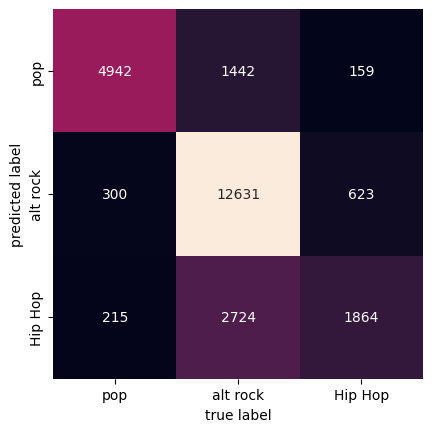

In [94]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

mat = confusion_matrix(test_df.ranker_genre, predicted)
sns.heatmap(
    mat.T, square=True, annot=True, fmt='d', cbar=False,
    xticklabels=genres, 
    yticklabels=genres
)
plt.xlabel('true label')
plt.ylabel('predicted label');

Per concludere si rimanda in calce ai risultati relativi a:
1. Precision: capacità di classificazione corretta degli elementi dell'insieme che sta venendo considerato;
2. Recall: capacità di ottenimento di tutti gli elementi interessanti al fine dell'analisi;
3. Fscore: misura di accuratezza basata dalla combinazione di *precision* e *recall*;



In [95]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, fscore, support = precision_recall_fscore_support(test_df.ranker_genre, predicted)

for n,genre in enumerate(genres):
    genre = genre.upper()
    print(genre+'_precision: {}'.format(precision[n]))
    print(genre+'_recall: {}'.format(recall[n]))
    print(genre+'_fscore: {}'.format(fscore[n]))
    print(genre+'_support: {}'.format(support[n]))
    print()

POP_precision: 0.7553110194100565
POP_recall: 0.9056258017225581
POP_fscore: 0.8236666666666665
POP_support: 5457

ALT ROCK_precision: 0.9319020215434558
ALT ROCK_recall: 0.7519795201524082
ALT ROCK_fscore: 0.8323284241046423
ALT ROCK_support: 16797

HIP HOP_precision: 0.3880907765979596
HIP HOP_recall: 0.7044595616024187
HIP HOP_fscore: 0.5004698617264062
HIP HOP_support: 2646



Considerando tutti i risultati

In [100]:
text_clf.predict(
[
    "[Intro: Tyler, The Creator]",
    "Okay, okay, okay, okay, okay, okay, o-",
    
    "[Verse 1: Tyler, The Creator]",
    "You live in my dream state",
    "Relocate my fantasy",
    "I stay in reality",
    "You live in my dream state",
    "Any time I count sheep",
    "That's the only time we make up, make up",
    "You exist behind my eyelids, my eyelids",
    "Now, I don't wanna wake up",
    
    "[Pre-Chorus: Tyler, The Creator, with Kali Uchis]",
    "20/20, 20/20 vision",
    "Cupid hit me, cupid hit me with precision, eye",
    "Wonder if you look both ways when you cross my mind",
    "I said, I said",
    "I'm sick of, sick of, sick of, sick of chasing",
    "You're the one that's always running through my daydreams, I",
    "I can only see your face when I close my eyes",
    "So...",
    
    "[Chorus: Kali Uchis & Tyler, The Creator]",
    "Can I get a kiss?",
    "And can you make it last forever?",
    "I said, I'm 'bout to go to war (Uh-huh)",
    "And I don't know if I'ma see you again",
    "Can I get a kiss? (Can I?)",
    "And can you make it last forever? (Can you?)",
    "I said, I'm 'bout to go to war (I'm 'bout to)",
    "And I don't know if I'ma see you again",
    "Ugh, switch it up",
    
    "[Verse 2: Tyler, The Creator]",
    "I said, okay, okay, okay, okey-dokey, my infatuation",
    "Is translating to another form of what you call it? (Love)",
    "Oh yeah, oh yeah, oh yeah, I ain't met you, I've been looking",
    "Stop the waiting 'fore I stop the chasing, like an alcoholic",
    "You don't understand me—what the fuck do you mean?",
    "It's them rose-tinted cheeks, yeah, it's them dirt-colored eyes",
    "Sugar-honey iced tea, bumblebee on the scene",
    "Yeah, I'd give up my bakery to have a piece of your pie",
    "Ugh!",
    
    "[Pre-Chorus: Tyler, The Creator, with Kali Uchis]",
    "20/20, 20/20 vision",
    "Cupid hit me, cupid hit me with precision, eye",
    "Wonder if you look both ways when you cross my mind",
    "I said, I said",
    "I'm sick of, sick of, sick of, sick of chasing",
    "You're the one that's always running through my daydreams, I",
    "I can only see your face when I close my eyes",
    "So...",
    
    "[Chorus: Kali Uchis]",
    "Can I get a kiss? (Can I get a kiss?)",
    "And can you make it last forever? (Make it last forever)",
    "I said I'm 'bout to go to war ('Bout to go to war)",
    "I don't know if I'ma see you again (See you again)",
    "Can I get a kiss? (Can I?)",
    "And can you make it last forever? (Can you?)",
    "I said I'm 'bout to go to war ('Bout to)",
    "And I don't know if I'ma see you again",
    "[Outro: Tyler, The Creator & Kali Uchis]",
    "Okay, okay, okay, okay, okay, okay, okay, o—",
    "(La la, la la la la, la la)",
    "Okay, okay, okay, okay, okay, okay, okay, o—",
    "(La la, la la la, la la)",
    "Okay, okay, okay, okay, okay, okay, okay, o—",
    "(La la, la la la la, la la",
    "La la, la la la la)",
    "One more time?"
    ]
    )

array(['Hip Hop', 'Hip Hop', 'Hip Hop', 'alt rock', 'pop', 'alt rock',
       'alt rock', 'Hip Hop', 'pop', 'alt rock', 'alt rock', 'Hip Hop',
       'alt rock', 'Hip Hop', 'pop', 'Hip Hop', 'alt rock', 'pop', 'pop',
       'Hip Hop', 'Hip Hop', 'pop', 'pop', 'alt rock', 'alt rock', 'pop',
       'pop', 'alt rock', 'alt rock', 'Hip Hop', 'Hip Hop', 'Hip Hop',
       'alt rock', 'pop', 'alt rock', 'Hip Hop', 'alt rock', 'Hip Hop',
       'alt rock', 'Hip Hop', 'Hip Hop', 'alt rock', 'Hip Hop', 'pop',
       'Hip Hop', 'alt rock', 'pop', 'pop', 'Hip Hop', 'Hip Hop', 'pop',
       'pop', 'alt rock', 'pop', 'pop', 'pop', 'alt rock', 'alt rock',
       'Hip Hop', 'Hip Hop', 'Hip Hop', 'Hip Hop', 'Hip Hop', 'Hip Hop',
       'Hip Hop', 'Hip Hop', 'pop'], dtype='<U8')